In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader
from torch import  optim

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import glob

##### Define data paths

In [2]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\8_week\\data\\img\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\8_week\\data\\msk\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.8

#length of image and mask folder is the same
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


25


Preprocess the dataset

In [3]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
#         self.num_classes = num_classes
#         self.transforms = transforms

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        
        ####
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


In [4]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 2, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 2, shuffle = False)

### My Networks

In [5]:
class DiscriminatorNet(torch.nn.Module):
    
    #3 hidden-layer discriminative nn
    
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        input_dim = 256+256
        output_dim = 1
        self.label_embedding = nn.Embedding (10,10)
        
        self.hidden0=nn.Sequential(
            nn.Conv2d(1,64,kernel_size=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden1=nn.Sequential(
            nn.Conv2d(64,128,kernel_size=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.hidden2=nn.Sequential(
            nn.Conv2d(128,256,kernel_size=2, stride=2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        
        self.out=nn.Sequential(
            nn.Conv2d(256,1,kernel_size=2, stride=2),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x,msk):
#         c = self.label_embedding(labels)
        x = torch.cat([x,msk])

        output = self.hidden0(x)
        output = self.hidden1(output)
        output = self.hidden2(output)
        output = self.out(output)
        return output
        


In [ ]:
#BCE loss example
#####
m = nn.Sigmoid()
loss = nn.BCELoss()
input = torch.randn((2, 1, 16, 16), requires_grad=True)
target = torch.ones(2, 1, 16, 16).random_(2)
pred = discriminator()
output = loss(m(pred), ones)
output.backward()
print(output)
#####

In [ ]:
#example to pass from BCE loss


image = torch.rand(1,1,256,256).to(device)
mask = torch.rand(1,1,256,256).to(device)
x = torch.cat([image,mask])
# x.shape
pred = discriminator(image,mask)
ones = torch.ones(pred.shape).to(device)
ones.shape
pred.shape
loss = nn.BCELoss()
l=loss(pred,ones)
print(ones.shape)
print(l)

In [6]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [7]:
class Generator_UNet(nn.Module):
    def __init__(self):
        super(Generator_UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) # 
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8) 
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
        
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))
        
        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
        
        x = self.out(x)
        
        return x

In [ ]:
def noise(size):
    #1-d vector of gaussian sampled random values
    
    n= Variable(torch.randn(size,100))
    #pass to the GPU
    if torch.cuda.is_available(): return n.cuda()
    return n

In [8]:
if torch.cuda.is_available():
    device = 'cuda'

In [9]:
class adversarialModel(object):
    def __init__(self, num_epochs=500, samples=3, batch=3, betas=(0.5,0.5),
                g_lr=0.002, d_lr=0.001, size=64, lat_vec =200,
                data_path='output/models/',dataloader = train_loader, transforms=None):
           #define parameters
        self.num_epochs=num_epochs
        self.samples = samples
        self.batch = batch
        self.betas = betas
        self.g_lr = g_lr
        self.d_lr = d_lr
        self.size = size
        self.latent = lat_vec
        self.dataset = 'input_data'
        self.name = 'adversarialModel'
        
        self.generator = Generator_UNet()
        self.discriminator = DiscriminatorNet()
        
        self.optim_g = optim.Adam(self.generator.parameters(), lr = self.g_lr, betas =self.betas)
        self.optim_d = optim.Adam(self.discriminator.parameters(), lr = self.d_lr, betas =self.betas)
        self.bce_loss = nn.BCELoss()
        self.L1_loss = nn.L1Loss()
        
        self.generator.to(device)
        self.discriminator.to(device)
        
        #dataset,dataloader
        self.dataloader = dataloader
        
    def train(self):
        for epoch in range(self.num_epochs):
            if(epoch%10==0): print('Epoch : ', epoch)
            
            for i, (images, masks) in enumerate(self.dataloader):
                
                images =images.to(device)
                masks = masks.to(device)
                #discriminator loss
                self.optim_d.zero_grad()
                
                fake_images = self.generator(masks)
                pred_real = self.discriminator(images, masks)
                ones = torch.ones(pred_real.shape).to(device)
                
                pred_fake = self.discriminator(fake_images, masks)
                zeros = torch.zeros(pred_fake.shape).to(device)
                
                loss_dicriminator_real = self.bce_loss(pred_real,ones)#scheduler
                loss_dicriminator_fake = self.bce_loss(pred_fake,zeros)#*scheduler
                loss_discriminator = loss_dicriminator_real + loss_dicriminator_fake
                
                loss_discriminator.backward()
                self.optim_d.step()
                
                #generator loss
                self.optim_g.zero_grad()
                
                fake_images = self.generator(masks)
                loss_generator_bce = self.bce_loss(self.discriminator(fake_images,masks),ones)
                loss_generator_l1 = self.L1_loss(fake_images,images) #*scheduler
                loss_generator = loss_generator_bce + loss_generator_l1
                
                loss_generator.backward()
                self.optim_g.step()
                
                if(epoch%10 == 0):
                    #save(masks,images,fake_images,output_dir,epoch )
                    print("generator loss: ",loss_generator)
                    print("discriminator loss: ",loss_discriminator)
            
        def save(self, imgA, imgB, imgG, filepath, epoch):
            mask_data = imgA_data
            msk = mask_data.cpu().float().numpy()
            msk = msk.astype(np.uint8)
            path_msk = os.path.join(filepath, '%s.png' % (epoch, '_msk'))
            
            image_data = imgB.data
            img = image_data.cpu().float().numpy()
            img = img.astype(np.uint8)
            path_img = os.path.join(filepath, '%s.png' % (epoch, '_img'))
            
            fake_data = imgG.data
            fake = fake_data.cpu().float().numpy()
            fake = fake.astype(np.uint8)
            path_fake = os.path.join(filepath, '%s.png' % (epoch, '_fake'))
            
            scipy.misc.imsave(path_msk, msk)
            scipy.misc.imsave(path_img, img)
            scipy.misc.imsave(path_fake, fake)
            
    

In [ ]:
out = adversarialModelmodel.discriminator()

In [10]:
model = adversarialModel(dataloader = train_loader)

In [11]:
model.train()

Epoch :  0
generator loss:  tensor(0.9836, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3883, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(1.2623, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3864, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(1.4588, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3681, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(1.0621, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3675, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.9501, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3604, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.9579, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3719, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.9054, device='cuda:0', grad_fn=<AddBackward0>)
discriminator lo

generator loss:  tensor(0.8559, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4268, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8747, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3836, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8083, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3466, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.9173, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3454, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8123, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3660, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  60
generator loss:  tensor(0.7517, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3775, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8731, device='cuda:0', grad_fn=<AddBackward0>)
discriminator l

Epoch :  110
generator loss:  tensor(0.8204, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4019, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7967, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3638, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7194, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3495, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7739, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3742, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7841, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3926, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8105, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3189, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8003, device='cuda:0', grad_fn=<AddBackward0>)
discriminator 

generator loss:  tensor(0.7591, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3765, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7447, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3880, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7420, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3811, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7796, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3886, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7113, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3734, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7581, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3817, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  170
generator loss:  tensor(0.7306, device='cuda:0', grad_fn=<AddBackward0>)
discriminator 

generator loss:  tensor(0.7236, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3810, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  220
generator loss:  tensor(0.7284, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3670, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7066, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3870, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3862, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7255, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3783, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7579, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3833, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7104, device='cuda:0', grad_fn=<AddBackward0>)
discriminator 

generator loss:  tensor(0.7367, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3811, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7016, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3861, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7239, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3922, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7372, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3841, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7594, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3813, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7032, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3823, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7532, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor

generator loss:  tensor(0.7364, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3829, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7312, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3571, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  330
generator loss:  tensor(0.7083, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3628, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7708, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3861, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7395, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3915, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7018, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3967, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7121, device='cuda:0', grad_fn=<AddBackward0>)
discriminator 

generator loss:  tensor(0.7800, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3897, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7554, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3603, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.6819, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3507, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8058, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.4125, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8311, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3894, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.6715, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3971, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7370, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor

generator loss:  tensor(0.8213, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2337, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.6840, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3254, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.9700, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2258, device='cuda:0', grad_fn=<AddBackward0>)
Epoch :  440
generator loss:  tensor(0.7344, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3644, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8708, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3861, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7052, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.2957, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7941, device='cuda:0', grad_fn=<AddBackward0>)
discriminator 

generator loss:  tensor(0.6635, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3530, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8628, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3658, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8031, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3103, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7340, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3833, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.8003, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3533, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.7066, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor(1.3337, device='cuda:0', grad_fn=<AddBackward0>)
generator loss:  tensor(0.6938, device='cuda:0', grad_fn=<AddBackward0>)
discriminator loss:  tensor

In [ ]:
loss = nn.BCELoss()

# Number of steps to apply to the discriminator
d_steps = 1

# Number of epochs
num_epochs = 200

batch_size = 100

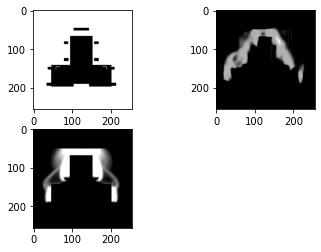

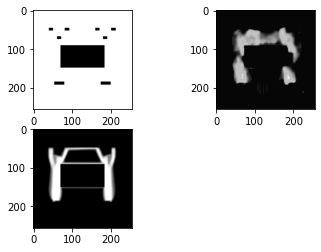

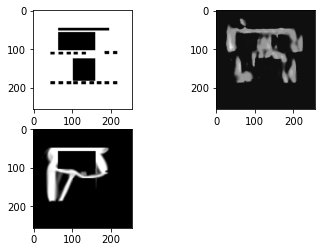

In [12]:
for i, (images, masks) in enumerate(test_loader):
    masks = masks.to(device)
    images = images.to(device)
    output = model.generator(masks)
    softmax = torch.nn.functional.log_softmax(output, dim=1)
#     loss = model.bce_loss(output, images)
#     print("loss:", loss)
    #print("output shape:", output.shape)
    #print("loss:", loss)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()),cmap = 'gray')
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()),cmap = 'gray')
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()),cmap = 'gray')
    
    plt.show()
